(week11:earthcare)=
# Reading earthcare level1b data

This notebook does a quick inspection of one of the earthcare cases, with
plots of the radar reflectivity and doppler velocity.  The earthcare data
is stored in [hdf5](https://docs.h5py.org/en/stable/) format, which is also
the underlying data format for netcdf.  Unlike netcdf, the files don't supply
dimensions or coordinates, so we have to figure out those ourselves.

## Installation

- Download a case folder from the satdata/earthcare folder on our
[gdrive folder](https://drive.google.com/drive/folders/1-D6y9MlE8LZRLZg-qRCxPZSgar8kGjBT?usp=drive_link)

- fetch and rebase from upstream/main to get this notebook in week11

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import pyproj
from matplotlib import pyplot as plt
import datetime
import pytz
import pyproj

## Find the case files

Organize them in a dictionary keyed by the case name, which
is at the start of the relative file path.  pathlib has a function that
finds the relative path, and also can break the folder path into 
its various parts

In [2]:
data_dir = Path().home() / 'repos/a301/satdata/earthcare'
radar_filepaths = list(data_dir.glob("**/*.h5"))
filepaths=dict()
for filepath in radar_filepaths:
    relpath = filepath.relative_to(data_dir)
    casename = relpath.parts[0]
    filepaths[casename]=filepath
    

In [3]:
def sort_keys(the_case):
    number = the_case[4:]
    return int(number)


In [4]:
sorted_keys = list(filepaths.keys())
sorted_keys.sort(key=sort_keys)
casenum = 'case4'
#sorted_keys

## Read the data and metadata

These are netcdf files, so no dimensions or coordinates, we'll need to
create these.  Start by naming the time and height dimensions

In [5]:
cpr_data = xr.open_dataset(filepaths[casenum], engine='h5netcdf', group='/ScienceData/Data',
                            decode_times=True,  phony_dims='access')
cpr_data = cpr_data.rename_dims({'phony_dim_0':'time','phony_dim_1': 'height'})

cpr_meta = xr.open_dataset(filepaths[casenum], engine='h5netcdf', group='/ScienceData/Geo',
                           decode_times=True, phony_dims='access')
cpr_meta = cpr_meta.rename_dims({'phony_dim_0':'time','phony_dim_1': 'height'})

In [6]:
cpr_meta

<xarray.Dataset> Size: 10MB
Dimensions:                 (time: 9946, height: 218, phony_dim_2: 1)
Dimensions without coordinates: time, height, phony_dim_2
Data variables: (12/25)
    binHeight               (time, height) float32 9MB ...
    latitude                (time) float64 80kB ...
    longitude               (time) float64 80kB ...
    navigationLandWaterFlg  (time) float32 40kB ...
    pitchAngle              (time) float32 40kB ...
    processingFrameNo       (time) float32 40kB ...
    ...                      ...
    surfaceElevation        (time) float32 40kB ...
    timeFlag                (time) float32 40kB ...
    xPosition               (time) float64 80kB ...
    yPosition               (time) float64 80kB ...
    yawAngle                (time) float32 40kB ...
    zPosition               (time) float64 80kB ...

## construct height, time, distance coords

### get times

In [7]:
def find_times(filepath):
    """
    times are stored as seconds after Jan 1, 2000
    use the datetime.timedelta function to increment from
    that start time

    Also set the timezone as utc
    """
    cpr_meta = xr.open_dataset(filepath, engine='h5netcdf', group='/ScienceData/Geo',
                           decode_times=False, phony_dims='access')
    times = cpr_meta['profileTime'].data
    start_time = datetime.datetime(2000,1,1,0,0,0)
    the_times =[start_time + datetime.timedelta(seconds=item) for item in times]
    the_times = [item.replace(tzinfo = pytz.utc) for item in the_times]
    return the_times

In [8]:
the_times = find_times(filepaths[casenum])
the_times[:4]

[datetime.datetime(2024, 12, 13, 22, 43, 31, 511866, tzinfo=<UTC>),
 datetime.datetime(2024, 12, 13, 22, 43, 31, 580652, tzinfo=<UTC>),
 datetime.datetime(2024, 12, 13, 22, 43, 31, 649437, tzinfo=<UTC>),
 datetime.datetime(2024, 12, 13, 22, 43, 31, 718223, tzinfo=<UTC>)]

### print the case times

In [9]:
for casename in sorted_keys:
    filepath = filepaths[casename]
    the_times = find_times(filepath)
    print(casename, the_times[0], the_times[-1])

case4 2024-12-13 22:43:31.511866+00:00 2024-12-13 22:55:21.904667+00:00
case6 2024-12-25 20:04:09.702314+00:00 2024-12-25 20:16:00.055151+00:00
case7 2024-12-27 19:53:15.007300+00:00 2024-12-27 20:05:05.358234+00:00
case9 2025-01-17 20:14:51.729728+00:00 2025-01-17 20:26:42.075556+00:00
case11 2025-01-19 18:31:04.489242+00:00 2025-01-19 18:42:54.702278+00:00
case12 2025-01-30 22:53:44.522380+00:00 2025-01-30 23:05:34.735525+00:00
case13 2025-02-13 18:30:54.491970+00:00 2025-02-13 18:42:44.837739+00:00
case15 2025-02-25 18:56:05.332980+00:00 2025-02-25 19:07:55.542302+00:00
case17 2025-02-16 19:00:23.101428+00:00 2025-02-16 19:12:13.312624+00:00
case19 2025-01-18 19:22:59.248577+00:00 2025-01-18 19:34:49.594296+00:00
case20 2024-12-27 19:53:15.007300+00:00 2024-12-27 20:05:05.358234+00:00
case21 2024-12-25 20:04:09.702314+00:00 2024-12-25 20:16:00.055151+00:00
case22 2024-11-03 20:16:08.522453+00:00 2024-11-03 20:27:58.909370+00:00
case25 2024-09-05 20:19:53.853945+00:00 2024-09-05 20:3

### get binheights

In [10]:
def get_binheights(cpr_meta):
    """
    the radar bin heights are stored for every radar pulse.  If the terrain is
    roughly level, these should be the same pulse to pulse, so just use the
    first one

    Some radar height bins are missing, so fill those in by finding the average
    distance between bins and using that as an increment

    Questions -- what does [...] accomplish here? 
    """
    the_bins = cpr_meta.binHeight[...]
    the_bins = the_bins[0,:].data
    diff_bins = np.diff(the_bins)
    del_y = float(np.nanmean(diff_bins))
    new_y = [float(the_bins[0])]
    for count,old_y in enumerate(the_bins[1:]):
        if np.isnan(old_y):
            new_y.append(float(new_y[count]) + float(del_y))
        else:
            new_y.append(float(old_y))
    return np.array(new_y)

heights = get_binheights(cpr_meta)

### get the along-track distance

We want to turn time into distance, so use pyproj to
find the great circle distance between each set of pulses,
using their lon, lat coords

In [11]:
great_circle=pyproj.Geod(ellps='WGS84')
meters2km = 1.e-3
def calc_distance(lonvec,latvec):
    distance=[0]
    startlon,startlat = lonvec[0],latvec[0]
    for lon,lat in zip(lonvec[1:],latvec[1:]):
        azi12,azi21,step= great_circle.inv(startlon,startlat,lon,lat)
        distance.append(distance[-1] + step)
        startlon,startlat = lon, lat
    distance=np.array(distance)*meters2km
    return distance

In [12]:
lonvec = cpr_meta['longitude'].data
latvec = cpr_meta['latitude'].data
distance = calc_distance(lonvec, latvec)
distance[:4]

array([0.        , 0.50020804, 1.00041453, 1.50069449])

## add time, height coords

In [13]:
# coords = dict(time=("time", the_times),
#               height=("height",heights))
# cpr_meta = cpr_meta.assign_coords(coords=coords)
# cpr_data = cpr_data.assign_coords(coords=coords)

## plot the radar reflectivity

In [14]:
radar = cpr_data['radarReflectivityFactor'].T
radar.shape

(218, 9946)

In [15]:
dbZ = 10*np.log10(radar)

/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [16]:
len(distance),dbZ.shape,len(heights)

(9946, (218, 9946), 218)

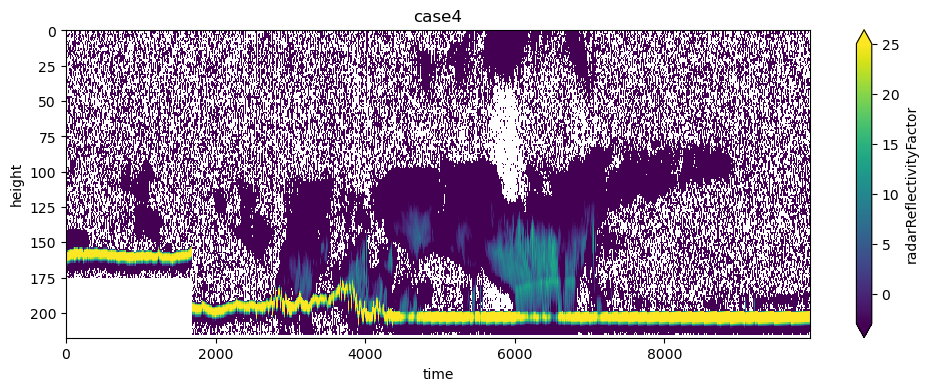

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dbZ.plot.pcolormesh(yincrease=False,vmin=-3,vmax=25);
ax.set_title(casenum);

## plot the doppler velocity

In [18]:
velocity = cpr_data['dopplerVelocity'].T

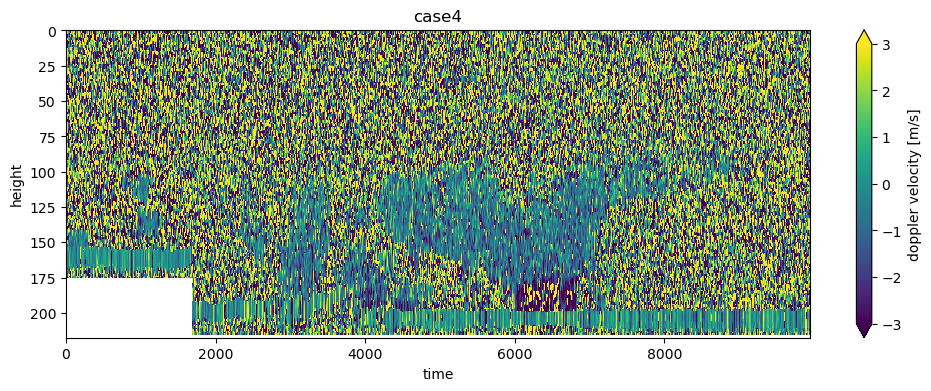

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
velocity.plot.pcolormesh(yincrease=False,vmin=-3,vmax=3);
ax.set_title(casenum);

## Your assignment

Pick one of the available earthcare cases, and find the closest GOES 16 image to the
central time of the earthcare segment.   Plot the eathcare ground track on top
of the clipped goes false color image